# Stable Yield Retrospective
Quantitative evaluation of stable yield success criteria and modeling of TACo staker longevity / cohort degradation.

The following code will set UPDATE variable. When `True`, the Dune queries will be executed so the data be analyzed will be updated, i.e., the most recent staking, authorizations, etc events will be collected.

Note that, for this, some API key are needed (Dune, Infura/Alchemy). Check `README.md` and `.env.example` files for more info.

In [1]:
import os
import pandas as pd
import dotenv
from dune_client.client import DuneClient
from dune_client.query import QueryBase
from web3 import Web3
from web3.middleware import ExtraDataToPOAMiddleware

# Set to True to update the data from Dune
UPDATE = False

dotenv.load_dotenv(".env")

coordinator_abi = '[{"inputs":[{"internalType":"contract ITACoChildApplication","name":"_application","type":"address"}],"stateMutability":"nonpayable","type":"constructor"},{"inputs":[],"name":"AccessControlBadConfirmation","type":"error"},{"inputs":[{"internalType":"uint48","name":"schedule","type":"uint48"}],"name":"AccessControlEnforcedDefaultAdminDelay","type":"error"},{"inputs":[],"name":"AccessControlEnforcedDefaultAdminRules","type":"error"},{"inputs":[{"internalType":"address","name":"defaultAdmin","type":"address"}],"name":"AccessControlInvalidDefaultAdmin","type":"error"},{"inputs":[{"internalType":"address","name":"account","type":"address"},{"internalType":"bytes32","name":"neededRole","type":"bytes32"}],"name":"AccessControlUnauthorizedAccount","type":"error"},{"inputs":[{"internalType":"address","name":"target","type":"address"}],"name":"AddressEmptyCode","type":"error"},{"inputs":[{"internalType":"address","name":"account","type":"address"}],"name":"AddressInsufficientBalance","type":"error"},{"inputs":[],"name":"FailedInnerCall","type":"error"},{"inputs":[],"name":"InvalidInitialization","type":"error"},{"inputs":[],"name":"NotInitializing","type":"error"},{"inputs":[{"internalType":"uint8","name":"bits","type":"uint8"},{"internalType":"uint256","name":"value","type":"uint256"}],"name":"SafeCastOverflowedUintDowncast","type":"error"},{"inputs":[{"internalType":"address","name":"token","type":"address"}],"name":"SafeERC20FailedOperation","type":"error"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"uint32","name":"ritualId","type":"uint32"},{"indexed":true,"internalType":"address","name":"node","type":"address"},{"indexed":false,"internalType":"bytes32","name":"aggregatedTranscriptDigest","type":"bytes32"}],"name":"AggregationPosted","type":"event"},{"anonymous":false,"inputs":[],"name":"DefaultAdminDelayChangeCanceled","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint48","name":"newDelay","type":"uint48"},{"indexed":false,"internalType":"uint48","name":"effectSchedule","type":"uint48"}],"name":"DefaultAdminDelayChangeScheduled","type":"event"},{"anonymous":false,"inputs":[],"name":"DefaultAdminTransferCanceled","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"newAdmin","type":"address"},{"indexed":false,"internalType":"uint48","name":"acceptSchedule","type":"uint48"}],"name":"DefaultAdminTransferScheduled","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"uint32","name":"ritualId","type":"uint32"},{"indexed":false,"internalType":"bool","name":"successful","type":"bool"}],"name":"EndRitual","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"contract IFeeModel","name":"feeModel","type":"address"}],"name":"FeeModelApproved","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint64","name":"version","type":"uint64"}],"name":"Initialized","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint16","name":"oldSize","type":"uint16"},{"indexed":false,"internalType":"uint16","name":"newSize","type":"uint16"}],"name":"MaxDkgSizeChanged","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"uint32","name":"ritualId","type":"uint32"},{"indexed":true,"internalType":"address","name":"participant","type":"address"},{"components":[{"internalType":"bytes32","name":"word0","type":"bytes32"},{"internalType":"bytes32","name":"word1","type":"bytes32"},{"internalType":"bytes32","name":"word2","type":"bytes32"}],"indexed":false,"internalType":"struct BLS12381.G2Point","name":"publicKey","type":"tuple"}],"name":"ParticipantPublicKeySet","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"pool","type":"address"}],"name":"ReimbursementPoolSet","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"uint32","name":"ritualId","type":"uint32"},{"indexed":true,"internalType":"address","name":"previousAuthority","type":"address"},{"indexed":true,"internalType":"address","name":"newAuthority","type":"address"}],"name":"RitualAuthorityTransferred","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"uint32","name":"ritualId","type":"uint32"},{"indexed":false,"internalType":"uint32","name":"endTimestamp","type":"uint32"}],"name":"RitualExtended","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"bytes32","name":"role","type":"bytes32"},{"indexed":true,"internalType":"bytes32","name":"previousAdminRole","type":"bytes32"},{"indexed":true,"internalType":"bytes32","name":"newAdminRole","type":"bytes32"}],"name":"RoleAdminChanged","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"bytes32","name":"role","type":"bytes32"},{"indexed":true,"internalType":"address","name":"account","type":"address"},{"indexed":true,"internalType":"address","name":"sender","type":"address"}],"name":"RoleGranted","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"bytes32","name":"role","type":"bytes32"},{"indexed":true,"internalType":"address","name":"account","type":"address"},{"indexed":true,"internalType":"address","name":"sender","type":"address"}],"name":"RoleRevoked","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"uint32","name":"ritualId","type":"uint32"}],"name":"StartAggregationRound","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"uint32","name":"ritualId","type":"uint32"},{"indexed":true,"internalType":"address","name":"authority","type":"address"},{"indexed":false,"internalType":"address[]","name":"participants","type":"address[]"}],"name":"StartRitual","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint32","name":"oldTimeout","type":"uint32"},{"indexed":false,"internalType":"uint32","name":"newTimeout","type":"uint32"}],"name":"TimeoutChanged","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"uint32","name":"ritualId","type":"uint32"},{"indexed":true,"internalType":"address","name":"node","type":"address"},{"indexed":false,"internalType":"bytes32","name":"transcriptDigest","type":"bytes32"}],"name":"TranscriptPosted","type":"event"},{"inputs":[],"name":"DEFAULT_ADMIN_ROLE","outputs":[{"internalType":"bytes32","name":"","type":"bytes32"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"TREASURY_ROLE","outputs":[{"internalType":"bytes32","name":"","type":"bytes32"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"acceptDefaultAdminTransfer","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"application","outputs":[{"internalType":"contract ITACoChildApplication","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"contract IFeeModel","name":"feeModel","type":"address"}],"name":"approveFeeModel","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"newAdmin","type":"address"}],"name":"beginDefaultAdminTransfer","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"cancelDefaultAdminTransfer","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint48","name":"newDelay","type":"uint48"}],"name":"changeDefaultAdminDelay","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address[]","name":"nodes","type":"address[]"}],"name":"cohortFingerprint","outputs":[{"internalType":"bytes32","name":"","type":"bytes32"}],"stateMutability":"pure","type":"function"},{"inputs":[],"name":"defaultAdmin","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"defaultAdminDelay","outputs":[{"internalType":"uint48","name":"","type":"uint48"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"defaultAdminDelayIncreaseWait","outputs":[{"internalType":"uint48","name":"","type":"uint48"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint16","name":"dkgSize","type":"uint16"},{"internalType":"uint16","name":"threshold","type":"uint16"}],"name":"expectedTranscriptSize","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"pure","type":"function"},{"inputs":[{"internalType":"uint32","name":"ritualId","type":"uint32"},{"internalType":"uint32","name":"duration","type":"uint32"}],"name":"extendRitual","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"contract IFeeModel","name":"","type":"address"}],"name":"feeModelsRegistry","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint32","name":"ritualId","type":"uint32"}],"name":"getAccessController","outputs":[{"internalType":"contract IEncryptionAuthorizer","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint32","name":"ritualId","type":"uint32"}],"name":"getAuthority","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint32","name":"ritualId","type":"uint32"}],"name":"getFeeModel","outputs":[{"internalType":"contract IFeeModel","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint32","name":"ritualId","type":"uint32"}],"name":"getInitiator","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint32","name":"ritualId","type":"uint32"},{"internalType":"address","name":"provider","type":"address"},{"internalType":"bool","name":"transcript","type":"bool"}],"name":"getParticipant","outputs":[{"components":[{"internalType":"address","name":"provider","type":"address"},{"internalType":"bool","name":"aggregated","type":"bool"},{"internalType":"bytes","name":"transcript","type":"bytes"},{"internalType":"bytes","name":"decryptionRequestStaticKey","type":"bytes"}],"internalType":"struct Coordinator.Participant","name":"","type":"tuple"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint32","name":"ritualId","type":"uint32"},{"internalType":"address","name":"provider","type":"address"}],"name":"getParticipantFromProvider","outputs":[{"components":[{"internalType":"address","name":"provider","type":"address"},{"internalType":"bool","name":"aggregated","type":"bool"},{"internalType":"bytes","name":"transcript","type":"bytes"},{"internalType":"bytes","name":"decryptionRequestStaticKey","type":"bytes"}],"internalType":"struct Coordinator.Participant","name":"","type":"tuple"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint32","name":"ritualId","type":"uint32"}],"name":"getParticipants","outputs":[{"components":[{"internalType":"address","name":"provider","type":"address"},{"internalType":"bool","name":"aggregated","type":"bool"},{"internalType":"bytes","name":"transcript","type":"bytes"},{"internalType":"bytes","name":"decryptionRequestStaticKey","type":"bytes"}],"internalType":"struct Coordinator.Participant[]","name":"","type":"tuple[]"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint32","name":"ritualId","type":"uint32"},{"internalType":"uint256","name":"startIndex","type":"uint256"},{"internalType":"uint256","name":"maxParticipants","type":"uint256"},{"internalType":"bool","name":"includeTranscript","type":"bool"}],"name":"getParticipants","outputs":[{"components":[{"internalType":"address","name":"provider","type":"address"},{"internalType":"bool","name":"aggregated","type":"bool"},{"internalType":"bytes","name":"transcript","type":"bytes"},{"internalType":"bytes","name":"decryptionRequestStaticKey","type":"bytes"}],"internalType":"struct Coordinator.Participant[]","name":"","type":"tuple[]"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"provider","type":"address"},{"internalType":"uint256","name":"ritualId","type":"uint256"}],"name":"getProviderPublicKey","outputs":[{"components":[{"internalType":"bytes32","name":"word0","type":"bytes32"},{"internalType":"bytes32","name":"word1","type":"bytes32"},{"internalType":"bytes32","name":"word2","type":"bytes32"}],"internalType":"struct BLS12381.G2Point","name":"","type":"tuple"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint32","name":"ritualId","type":"uint32"}],"name":"getProviders","outputs":[{"internalType":"address[]","name":"","type":"address[]"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint32","name":"ritualId","type":"uint32"}],"name":"getPublicKeyFromRitualId","outputs":[{"components":[{"internalType":"bytes32","name":"word0","type":"bytes32"},{"internalType":"bytes16","name":"word1","type":"bytes16"}],"internalType":"struct BLS12381.G1Point","name":"","type":"tuple"}],"stateMutability":"view","type":"function"},{"inputs":[{"components":[{"internalType":"bytes32","name":"word0","type":"bytes32"},{"internalType":"bytes16","name":"word1","type":"bytes16"}],"internalType":"struct BLS12381.G1Point","name":"dkgPublicKey","type":"tuple"}],"name":"getRitualIdFromPublicKey","outputs":[{"internalType":"uint32","name":"ritualId","type":"uint32"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint32","name":"ritualId","type":"uint32"}],"name":"getRitualState","outputs":[{"internalType":"enum Coordinator.RitualState","name":"","type":"uint8"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"bytes32","name":"role","type":"bytes32"}],"name":"getRoleAdmin","outputs":[{"internalType":"bytes32","name":"","type":"bytes32"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint16","name":"size","type":"uint16"}],"name":"getThresholdForRitualSize","outputs":[{"internalType":"uint16","name":"","type":"uint16"}],"stateMutability":"pure","type":"function"},{"inputs":[{"internalType":"uint32","name":"ritualId","type":"uint32"}],"name":"getTimestamps","outputs":[{"internalType":"uint32","name":"initTimestamp","type":"uint32"},{"internalType":"uint32","name":"endTimestamp","type":"uint32"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"bytes32","name":"role","type":"bytes32"},{"internalType":"address","name":"account","type":"address"}],"name":"grantRole","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"bytes32","name":"role","type":"bytes32"},{"internalType":"address","name":"account","type":"address"}],"name":"hasRole","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint32","name":"_timeout","type":"uint32"},{"internalType":"uint16","name":"_maxDkgSize","type":"uint16"},{"internalType":"address","name":"_admin","type":"address"}],"name":"initialize","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"initializeNumberOfRituals","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"contract IFeeModel","name":"feeModel","type":"address"},{"internalType":"address[]","name":"providers","type":"address[]"},{"internalType":"address","name":"authority","type":"address"},{"internalType":"uint32","name":"duration","type":"uint32"},{"internalType":"contract IEncryptionAuthorizer","name":"accessController","type":"address"}],"name":"initiateRitual","outputs":[{"internalType":"uint32","name":"","type":"uint32"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint32","name":"ritualId","type":"uint32"},{"internalType":"bytes","name":"evidence","type":"bytes"},{"internalType":"bytes","name":"ciphertextHeader","type":"bytes"}],"name":"isEncryptionAuthorized","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint32","name":"ritualId","type":"uint32"},{"internalType":"address","name":"provider","type":"address"}],"name":"isParticipant","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"provider","type":"address"}],"name":"isProviderPublicKeySet","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint32","name":"ritualId","type":"uint32"}],"name":"isRitualActive","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"maxDkgSize","outputs":[{"internalType":"uint16","name":"","type":"uint16"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"numberOfRituals","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"owner","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"pendingDefaultAdmin","outputs":[{"internalType":"address","name":"newAdmin","type":"address"},{"internalType":"uint48","name":"schedule","type":"uint48"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"pendingDefaultAdminDelay","outputs":[{"internalType":"uint48","name":"newDelay","type":"uint48"},{"internalType":"uint48","name":"schedule","type":"uint48"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint32","name":"ritualId","type":"uint32"},{"internalType":"bytes","name":"aggregatedTranscript","type":"bytes"},{"components":[{"internalType":"bytes32","name":"word0","type":"bytes32"},{"internalType":"bytes16","name":"word1","type":"bytes16"}],"internalType":"struct BLS12381.G1Point","name":"dkgPublicKey","type":"tuple"},{"internalType":"bytes","name":"decryptionRequestStaticKey","type":"bytes"}],"name":"postAggregation","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint32","name":"ritualId","type":"uint32"},{"internalType":"bytes","name":"transcript","type":"bytes"}],"name":"postTranscript","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"bytes32","name":"role","type":"bytes32"},{"internalType":"address","name":"account","type":"address"}],"name":"renounceRole","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"bytes32","name":"role","type":"bytes32"},{"internalType":"address","name":"account","type":"address"}],"name":"revokeRole","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"ritualId","type":"uint256"}],"name":"rituals","outputs":[{"internalType":"address","name":"initiator","type":"address"},{"internalType":"uint32","name":"initTimestamp","type":"uint32"},{"internalType":"uint32","name":"endTimestamp","type":"uint32"},{"internalType":"uint16","name":"totalTranscripts","type":"uint16"},{"internalType":"uint16","name":"totalAggregations","type":"uint16"},{"internalType":"address","name":"authority","type":"address"},{"internalType":"uint16","name":"dkgSize","type":"uint16"},{"internalType":"uint16","name":"threshold","type":"uint16"},{"internalType":"bool","name":"aggregationMismatch","type":"bool"},{"internalType":"contract IEncryptionAuthorizer","name":"accessController","type":"address"},{"components":[{"internalType":"bytes32","name":"word0","type":"bytes32"},{"internalType":"bytes16","name":"word1","type":"bytes16"}],"internalType":"struct BLS12381.G1Point","name":"publicKey","type":"tuple"},{"internalType":"bytes","name":"aggregatedTranscript","type":"bytes"},{"internalType":"contract IFeeModel","name":"feeModel","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"rollbackDefaultAdminDelay","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint16","name":"newSize","type":"uint16"}],"name":"setMaxDkgSize","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"components":[{"internalType":"bytes32","name":"word0","type":"bytes32"},{"internalType":"bytes32","name":"word1","type":"bytes32"},{"internalType":"bytes32","name":"word2","type":"bytes32"}],"internalType":"struct BLS12381.G2Point","name":"publicKey","type":"tuple"}],"name":"setProviderPublicKey","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"contract IReimbursementPool","name":"pool","type":"address"}],"name":"setReimbursementPool","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint32","name":"newTimeout","type":"uint32"}],"name":"setTimeout","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"bytes4","name":"interfaceId","type":"bytes4"}],"name":"supportsInterface","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"timeout","outputs":[{"internalType":"uint32","name":"","type":"uint32"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint32","name":"ritualId","type":"uint32"},{"internalType":"address","name":"newAuthority","type":"address"}],"name":"transferRitualAuthority","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"contract IERC20","name":"token","type":"address"}],"name":"withdrawAllTokens","outputs":[],"stateMutability":"nonpayable","type":"function"}]'

## Staking activity
Collection, sorting and analisys of Threshold Network staking activity.

### Update staking events
The following code will collect all the staking events up to current date from a Dune query ([Threshold Network Staking Events Dune query](./ThresholdNetworkStakingEvents.sql)) and update [raw_staking_events.csv](./raw_authorization_events.csv) file.

In [2]:
if UPDATE:
    dune = DuneClient.from_env()

    query = QueryBase(
        name="Staking Events",
        query_id=4418882,  # https://dune.com/queries/4418882
        params=[],
    )

    query_results = dune.run_query_dataframe(query=query, performance='medium')
    query_results.to_csv('raw_staking_events.csv', index=False)

2025-01-22 14:39:35,061 INFO dune_client.api.base executing 4418882 on medium cluster
2025-01-22 14:39:35,375 INFO dune_client.api.base waiting for query execution 01JJ73TRS18RDJ0TSCBCJFMWBN to complete: ExecutionState.PENDING (queue position: 23)
2025-01-22 14:39:36,462 INFO dune_client.api.base waiting for query execution 01JJ73TRS18RDJ0TSCBCJFMWBN to complete: ExecutionState.EXECUTING
2025-01-22 14:39:37,542 INFO dune_client.api.base waiting for query execution 01JJ73TRS18RDJ0TSCBCJFMWBN to complete: ExecutionState.EXECUTING


### Generate stake atomic history
The resulting data contains the historical amount for each stake. Each row contains the general stake status in the moment in which it was updated, i.e the staked, toppedUp or unstaked event was emitted.

In [3]:
staking_events = pd.read_csv(
    'raw_staking_events.csv', dtype={'amount': str})

staking_events["amount"] = staking_events["amount"].apply(int)

st_prov_list = staking_events.staking_provider.unique().tolist()

atomic_stakes_history = pd.DataFrame(
    index=staking_events.index, columns=['timestamp']+st_prov_list)

for index, row in staking_events.iterrows():
    if index == 0:
        atomic_stakes_history.iloc[index] = 0
        atomic_stakes_history.loc[index, 'timestamp'] = row.timestamp
        atomic_stakes_history.loc[index, row.staking_provider] = row.amount
    else:
        atomic_stakes_history.iloc[index] = atomic_stakes_history.iloc[index - 1]
        atomic_stakes_history.loc[index, 'timestamp'] = row.timestamp
        if row.event == "staked":
            atomic_stakes_history.loc[index, row.staking_provider] = row.amount
        elif row.event == "toppedUp":
            atomic_stakes_history.loc[index,
                                      row.staking_provider] += row.amount
        elif row.event == "unstaked":
            atomic_stakes_history.loc[index,
                                      row.staking_provider] -= row.amount

atomic_stakes_history["timestamp"] = pd.to_datetime(
    atomic_stakes_history["timestamp"])

### Generate stake history in a daily basis
The resulting data contains the general state of stakes for each day since the start of the staking mechanism.

In [4]:
start_date = atomic_stakes_history['timestamp'].iloc[0]
end_date = atomic_stakes_history['timestamp'].iloc[-1]

dates = pd.date_range(start=start_date, end=end_date, freq='D', normalize=True)

precise_stakes_history = pd.DataFrame(index=dates, columns=st_prov_list)

for index, row in precise_stakes_history.iterrows():
    if index == dates[0]:
        precise_stakes_history.iloc[0] = 0
    else:
        precise_stakes_history.loc[index] = precise_stakes_history.loc[index -
                                                                       pd.Timedelta(days=1)]

        day_events = atomic_stakes_history.loc[(atomic_stakes_history['timestamp'] < index) & (
            atomic_stakes_history['timestamp'] >= index - pd.Timedelta(days=1))]

        if not day_events.empty:
            precise_stakes_history.loc[index] = day_events.iloc[-1]

precise_stakes_history.to_csv('stakes_history.csv')

### Staking historical data analysis
Some plots showing the evolution of Threshold Network staking.

<Axes: title={'center': 'Total Staked Amount'}>

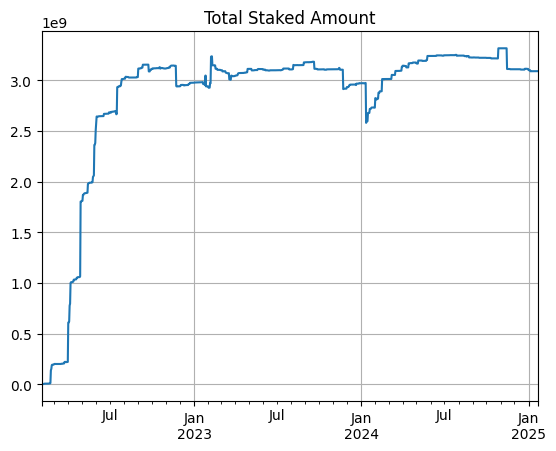

In [5]:
stakes_history = precise_stakes_history.map(
    lambda amount: int(amount/1e18))

stakes_history.sum(axis=1).plot(
    title='Total Staked Amount', grid=True)

## Application authorizations activity
Collection, sorting and analisys of Threshold Network applications authorizations activity.

Note that, although at this moment the Threshold Network host two applications (tBTC and TACo), technically these are made up of three different decentralized applications:

- Random Beacon: part of tBTC app.
- Wallet Registry (a.k.a tBTC): part of tBTC app.
- TACo.

### Update applications authorization events
The following code will collect all the apps authorization events up to current date from a Dune query([Threshold Network Authorization Events Dune query](./ThresholdNetworkAuthorizationEvents.sql)) and update [raw_authorization_events.csv](./raw_authorization_events.csv) file.

In [6]:
if UPDATE:
    dune = DuneClient.from_env()

    query = QueryBase(
        name="Apps Authorization Events",
        query_id=4544121,  # https://dune.com/queries/4544121
        params=[],
    )

    query_results = dune.run_query_dataframe(query=query, performance='medium')
    query_results.to_csv('raw_authorization_events.csv', index=False)

2025-01-22 14:39:40,362 INFO dune_client.api.base executing 4544121 on medium cluster
2025-01-22 14:39:40,631 INFO dune_client.api.base waiting for query execution 01JJ73TXXGNWB1CRN9658CFWR4 to complete: ExecutionState.PENDING (queue position: 23)
2025-01-22 14:39:41,708 INFO dune_client.api.base waiting for query execution 01JJ73TXXGNWB1CRN9658CFWR4 to complete: ExecutionState.EXECUTING
2025-01-22 14:39:42,784 INFO dune_client.api.base waiting for query execution 01JJ73TXXGNWB1CRN9658CFWR4 to complete: ExecutionState.EXECUTING


### Generate apps authorizations atomic history
The resulting data contains the historical auhorization balance of each stake for each application (TACo, tBTC, Random Beacon). The time index is the time in which each event was emitted.

Note that this will take a while (~4 min using MacBook Pro M1).

In [7]:
auth_events = pd.read_csv('raw_authorization_events.csv',
                          dtype={'amount_variation': str, 'current_balance': str})

auth_events['amount_variation'] = auth_events['amount_variation'].apply(int)
auth_events['current_balance'] = auth_events['current_balance'].apply(int)

st_prov_list = auth_events.staking_provider.unique().tolist()

auth_history_columns = []

for st_prov in st_prov_list:
    auth_history_columns.append((st_prov, 'taco'))
    auth_history_columns.append((st_prov, 'tbtc'))
    auth_history_columns.append((st_prov, 'randombeacon'))

atomic_auth_history = pd.DataFrame(
    index=auth_events.index, columns=auth_history_columns)
atomic_auth_history.columns = pd.MultiIndex.from_tuples(
    atomic_auth_history.columns, names=['staking_provider', 'app'])
atomic_auth_history.insert(0, 'timestamp', pd.Series(dtype='str'), True)

for index, row in auth_events.iterrows():
    if index == 0:
        atomic_auth_history.iloc[index] = 0

    else:
        atomic_auth_history.iloc[index] = atomic_auth_history.iloc[index - 1]

    atomic_auth_history.loc[index, 'timestamp'] = row.timestamp
    atomic_auth_history.loc[index, (row.staking_provider,
                                    row.application)] = row.current_balance

atomic_auth_history["timestamp"] = pd.to_datetime(
    atomic_auth_history["timestamp"])

### Generate authorization history in a daily basis

The resulting data contains the state of authorizations for each day since the start of staking mechanism.

In [8]:
start_date = atomic_auth_history['timestamp'].iloc[0]
end_date = atomic_auth_history['timestamp'].iloc[-1]

dates = pd.date_range(start=start_date, end=end_date, freq='D', normalize=True)

auth_history_daily = pd.DataFrame(index=dates, columns=auth_history_columns)
auth_history_daily.columns = pd.MultiIndex.from_tuples(
    auth_history_daily.columns, names=['staking_provider', 'app'])

for index, row in auth_history_daily.iterrows():
    if index == dates[0]:
        auth_history_daily.iloc[0] = 0

    else:
        auth_history_daily.loc[index] = auth_history_daily.loc[index -
                                                               pd.Timedelta(days=1)]

        day_events = atomic_auth_history.loc[(atomic_auth_history['timestamp'] < index) & (
            atomic_auth_history['timestamp'] >= index - pd.Timedelta(days=1))]

        if not day_events.empty:
            auth_history_daily.loc[index] = day_events.iloc[-1]

auth_history_daily.to_csv('auths_history.csv')

### Apps authorizations historical data analysis

Some plots showing the evolution of Threshold Network apps authorizations.

<Axes: title={'center': 'Cumulative app authorizations'}>

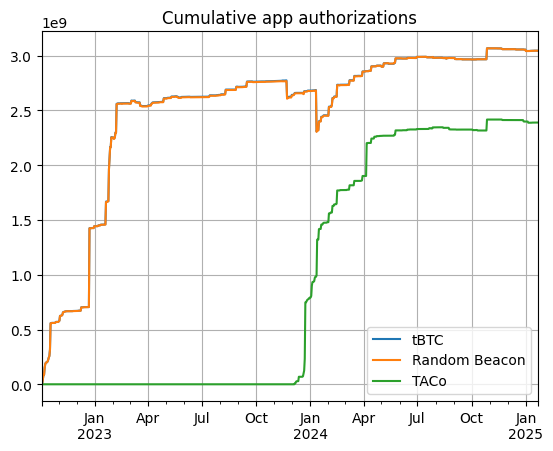

In [9]:
tbtc_auth_history = auth_history_daily.loc[:, (slice(
    None), 'tbtc')].map(lambda auth: int(auth/1e18))
rb_auth_history = auth_history_daily.loc[:, (slice(None), 'randombeacon')].map(
    lambda auth: int(auth/1e18))
taco_auth_history = auth_history_daily.loc[:, (slice(
    None), 'taco')].map(lambda auth: int(auth/1e18))

tbtc_auth_history.sum(axis=1).plot(
    title='Cumulative app authorizations', grid=True, legend=True, label='tBTC')
rb_auth_history.sum(axis=1).plot(title='Cumulative app authorizations',
                                 grid=True, legend=True, label='Random Beacon')
taco_auth_history.sum(axis=1).plot(
    title='Cumulative app authorizations', grid=True, legend=True, label='TACo')

## Ritual cohorts activity
This section is aimed to analyze the longevity / degradation of cohorts involved on TACo rituals. This will take as a representative sample cohorts of at least a certain size involved in TACo rituals.

### Update cohorts data
The following code will collect all the succesfully completed rituals up to current date from a Dune query ([Threshold Network Successful TACo Rituals](./ThresholdNetworkSuccessfulTACoRituals.sql)) and update [rituals.csv](./rituals.csv) file.

**Note** that the ritual participant addresses shown here is the original cohort, i.e., the addresses selected when the ritual was created.

In [10]:
if UPDATE:
    dune = DuneClient.from_env()

    w3 = Web3(Web3.HTTPProvider(os.getenv('POLYGON_URL_ENDPOINT')))
    w3.middleware_onion.inject(ExtraDataToPOAMiddleware, layer=0)

    coordinator = w3.eth.contract(
        address="0xE74259e3dafe30bAA8700238e324b47aC98FE755", abi=coordinator_abi)

    query = QueryBase(
        name="Apps Authorization Events",
        query_id=4577616,  # https://dune.com/queries/4577616
        params=[],
    )

    df = dune.run_query_dataframe(query=query, performance='medium')

    initTimestamps = []
    endTimestamps = []

    for ritualId in df.ritualId.tolist():
        try:
            init_unix_timestamp = coordinator.functions.rituals(ritualId).call()[
                1]
            end_unix_timestamp = coordinator.functions.rituals(ritualId).call()[
                2]
        # coordinator doesn't return data correctly for some rituals
        except:
            init_unix_timestamp = 0
            end_unix_timestamp = 0

        init_timestamp = pd.Timestamp(init_unix_timestamp, unit='s')
        end_timestamp = pd.Timestamp(end_unix_timestamp, unit='s')

        initTimestamps.append(init_timestamp)
        endTimestamps.append(end_timestamp)

    rituals = pd.DataFrame({'ritual_id': df.ritualId, 'init_timestamp': initTimestamps,
                           'end_timestamp': endTimestamps, 'participants': df.participants})

    # some rituals have to be discarded since coordinator doesn't return the data correctly
    first_ritual_date = pd.Timestamp('2023-12-18')
    rituals = rituals[(rituals['init_timestamp'] > first_ritual_date) & (
        rituals['end_timestamp'] > first_ritual_date)]

    rituals.to_csv('rituals.csv', index=False)

2025-01-22 14:43:39,151 INFO dune_client.api.base executing 4577616 on medium cluster
2025-01-22 14:43:39,453 INFO dune_client.api.base waiting for query execution 01JJ74274E70DNJM36FCMS7ZE2 to complete: ExecutionState.PENDING (queue position: 23)
2025-01-22 14:43:40,531 INFO dune_client.api.base waiting for query execution 01JJ74274E70DNJM36FCMS7ZE2 to complete: ExecutionState.PENDING (queue position: 23)
2025-01-22 14:43:41,616 INFO dune_client.api.base waiting for query execution 01JJ74274E70DNJM36FCMS7ZE2 to complete: ExecutionState.EXECUTING
2025-01-22 14:43:42,702 INFO dune_client.api.base waiting for query execution 01JJ74274E70DNJM36FCMS7ZE2 to complete: ExecutionState.EXECUTING
2025-01-22 14:43:43,790 INFO dune_client.api.base waiting for query execution 01JJ74274E70DNJM36FCMS7ZE2 to complete: ExecutionState.EXECUTING
2025-01-22 14:43:44,874 INFO dune_client.api.base waiting for query execution 01JJ74274E70DNJM36FCMS7ZE2 to complete: ExecutionState.EXECUTING
2025-01-22 14:43:4

### Analyze cohorts degradation

This code is going to take as sample the three most recently expired rituals with a cohort size of, at least, a certain value. The longevity and degradation of these cohorts is analized.

In [11]:
COHORT_MIN_SIZE = 30

rituals = pd.read_csv('rituals.csv', parse_dates=['init_timestamp', 'end_timestamp'])
rituals.participants = rituals.participants.apply(
    lambda x: x.strip('[]').split())
rituals['num_participants'] = rituals.participants.apply(len)

rituals_sample = rituals.loc[(rituals.num_participants >= COHORT_MIN_SIZE) & (
    rituals.end_timestamp <= pd.Timestamp.now())]

# taking the three most recent expired rituals
rituals_sample = rituals_sample.sort_values(by='end_timestamp').tail(3)